In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater

# PWD IS  /g/data/xv83/np1383/src_CAFE60_eqpac_analysis_codesrc_CAFE60_eqpac_analysis/16-transport_test.ipynb
import time
os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [2]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.158:43939,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load preprocessed Data

In [5]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40))

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

# Load Data
dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
# y is v and x is u directions?

adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural


cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
#cafe_co2_anth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s

upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups



upwelling_cafe_100=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-100,method='nearest') #
upwelling_cafe_300=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-300,method='nearest') #
upwelling_cafe_500=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-500,method='nearest') #
upwelling_cafe_700=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-700,method='nearest') #
upwelling_cafe_900=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=-900,method='nearest') #

upwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_100=(upwelling_cafe_100.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-100,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_300=(upwelling_cafe_300.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-300,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_500=(upwelling_cafe_500.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-500,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_700=(upwelling_cafe_700.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-700,method='nearest')*area_m2)#/1e6 # To Sverdrups

upwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling_900=(upwelling_cafe_900.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=-900,method='nearest')*area_m2)#/1e6 # To Sverdrups



anthflux=((cafe_co2_anth*-1)*area_m2)#/1e6 # Or maybe 9? # To Sverdrups (Because skin not m3? I have no idea).
flux=((cafe_co2*-1)*area_m2)#/1e6 #Or mabe 9? To Sverdrups


# EVERYTHING SHOULD BE IN MMOL/S


In [8]:
cafe_x_tx

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [9]:
# mmol/s
#10^9 kg/s

In [10]:
# Compare Area vs Transport??

In [11]:
#area_m2/1e6

### Check some of the vars to make sure they look ok

In [12]:
cafe_x_tx

#mmol/m3 * 1e9 KG/S (/1e6?)

<xarray.DataArray 'tx_trans' (time: 731, st_ocean: 30, lat: 140, lon_x: 171)>
dask.array<xarray-<this-array>, shape=(731, 30, 140, 171), dtype=float32, chunksize=(103, 30, 70, 57), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon_x     (lon_x) float64 120.0 121.0 122.0 123.0 ... 288.0 289.0 290.0
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:   time: mean
    long_name:      T-cell i-mass transport
    standard_name:  ocean_x_mass_transport
    units:          Sv (10^9 kg/s)
    valid_range:    [-1.00000002e+20  1.00000002e+20]

In [13]:
adic_cafe

<xarray.DataArray 'adic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 ...
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     adic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [14]:
dic_cafe

<xarray.DataArray 'dic' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
[521934000 values with dtype=float32]
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
Attributes:
    cell_methods:  time: mean
    long_name:     dic
    units:         mmol/m^3
    valid_range:   [-1000000.  1000000.]

In [15]:
cafe_co2_anth

<xarray.DataArray (time: 720, lat: 140, lon: 170)>
array([[[-8.12692815e-05, -8.05905293e-05, -8.20420464e-05, ...,
                     nan,             nan,             nan],
        [-6.27744885e-05, -6.36629266e-05, -6.60276419e-05, ...,
                     nan,             nan,             nan],
        [-4.99513044e-05, -5.13415143e-05, -5.46429619e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan, -2.59818335e-05, -3.11375188e-05, ...,
         -1.01243699e-04, -1.02947000e-04, -1.06701322e-04],
        [-1.92235748e-05, -3.19972460e-05, -3.46961024e-05, ...,
         -9.25098793e-05, -9.91586639e-05, -1.05985877e-04],
        [-2.11526640e-05, -3.40708648e-05, -3.36802186e-05, ...,
         -7.62597265e-05, -9.34339914e-05, -1.00215228e-04]],

       [[-4.17797819e-05, -3.93452137e-05, -3.69605914e-05, ...,
                     nan,             nan,             nan],
        [-4.07274892e-05, -3.91482645e-05, -3.71795686e-05, ...,
                     nan,             nan,             nan],
        [-4.05038336e-05, -3.78398254e-05, -3.61938655e-05, ...,
                     nan,             nan,             nan],
...
          4.58130380e-05,  3.81436475e-05,  3.83082443e-05],
        [ 6.15766112e-06,  1.95439279e-05,  2.09899772e-05, ...,
          7.02108446e-05,  6.37502671e-05,  5.76455386e-05],
        [ 1.10565015e-05,  2.25717340e-05,  2.25512740e-05, ...,
          6.59838988e-05,  6.79772347e-05,  7.34023342e-05]],

       [[-2.02712654e-05, -2.05903052e-05, -2.09384380e-05, ...,
                     nan,             nan,             nan],
        [-2.01107614e-05, -2.07197882e-05, -2.07053963e-05, ...,
                     nan,             nan,             nan],
        [-1.64308076e-05, -1.72205873e-05, -1.79971030e-05, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,  3.39869730e-05,  3.90992282e-05, ...,
          8.11240679e-05,  6.95347044e-05,  6.75038245e-05],
        [ 1.60184063e-05,  3.96328105e-05,  4.29397187e-05, ...,
          1.07914566e-04,  9.74847426e-05,  9.13539479e-05],
        [ 1.96226829e-05,  4.13808593e-05,  4.16727489e-05, ...,
          1.01620652e-04,  1.07105065e-04,  1.12273679e-04]]],
      dtype=float32)
Coordinates:
    ensemble  int32 25
    st_ocean  float64 5.0
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34

## Key Tracer Calculation and Save. 

In [16]:
# Run tracer transport Calculation
# This will do the two sides of the box but not vertical (bottom / top)> Make new calc to get wt transport?
calculate_horizontal_tracers=False
if calculate_horizontal_tracers==True:
    names=['anth_dic_cafe','dic_cafe']
    for i,tracer in enumerate([anth_dic_cafe,dic_cafe]):
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx
            tracer_v_tx=tracer_v_interp*cafe_y_tx

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport.nc')
        print('v saved')
        
anth_dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
anth_dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_u_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
dic_v_tx=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport.nc').__xarray_dataarray_variable__.chunk('auto')*1e6 #to mmol/s
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

# Test they look OK
test=False
if test==True:
    #chunk({'time':-1}).sel(time=slice('2000-01-01','2020-01-01')).
    anth_dic_v_tx.mean(dim='time').sel(lat=-3,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lon=180,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')
    plt.show()
    anth_dic_u_tx.mean(dim='time').sel(lat=0,method='nearest').plot()#(vmin=-20,vmax=20,cmap='bwr')

In [17]:
#cafe_y_tx_gm.sel(time='2010-01-01',lat_x=3,lon=180,method='nearest').plot()

In [18]:
calculate_horizontal_tracers_gm=False
if calculate_horizontal_tracers_gm==True:
    names=['dic_cafe']  #anth_dic_cafe
    for i,tracer in enumerate([dic_cafe]):# anth_dic_cafe
        tracer_u=tracer.rename({'lon':'lon_x'}).chunk('auto')
        tracer_v=tracer.rename({'lat':'lat_x'}).chunk('auto')

        tracer_u_interp=tracer_u.interp(lon_x=cafe_x_tx.lon_x) # U is X (lon)
        tracer_v_interp=tracer_v.interp(lat_x=cafe_y_tx.lat_x) # V is Y (lat)

        # Do need to take mean of adjacent pixels still or not?
        adjacent_boxes=False
        if adjacent_boxes==True:
            tracer_u_tx=tracer_u_interp.rolling(lat=2).mean()*cafe_x_tx.rolling(lon_x=2).mean()
            tracer_v_tx=tracer_v_interp.rolling(lon=2).mean()*cafe_y_tx.rolling(lat_x=2).mean()
        elif adjacent_boxes==False:
            tracer_u_tx=tracer_u_interp*cafe_x_tx_gm
            tracer_v_tx=tracer_v_interp*cafe_y_tx_gm

        # Rename back to main grid so we can use the coords easily
        tracer_u_tx=tracer_u_tx.rename({'lon_x':'lon'})
        tracer_v_tx=tracer_v_tx.rename({'lat_x':'lat'})
        print('saving')
        tracer_u_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_u_transport_gm.nc')
        print('u saved')
        tracer_v_tx.to_netcdf(f'/g/data/xv83/np1383/processed_data/physics_ds/{names[i]}_v_transport_gm.nc')
        print('v saved')
        
#anth_dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#anth_dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_u_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_u_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
#dic_v_tx_gm=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_cafe_v_transport_gm.nc').__xarray_dataarray_variable__.chunk('auto')
# Units of these should be mmolC/m3 to then SV(kg/s) = mmolC /s so MMol/s *10e6

## Calculate ENSO Months

In [19]:
#anth_dic_u_tx

In [20]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [21]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc(inputds,enso_months,cutoff=0,mean=False,printer=True,mmols_to_pgYr_convert=True,run_density_calc=True,lat=None,lon=None):
    ds=inputds.sel(time=enso_months).mean(dim='time')#.copy(deep=True)
    ds1=ds
    if mmols_to_pgYr_convert==True:   
        ds=(ds*60*60*24*12*365)/1e18 # From Seconds to Minute to Hour to Day to Year to Milligrams to Petagrams
           
        
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        print(f'Postive and negative sums {np.array(res)}')
        print(f'Total Sum {ds.sum().values}')
        #print(f'Total Sum Surface {ds.sel(st_ocean=slice(0,-100)).sum().values}')
        
        print(ds1.where(ds1>0).mean().values)
        try:
            print(density_tx.T)
        except:
            pass #Name Error?
    
    # MASK
    if run_density_calc==True:

        # NEED TO GET THE LAT OR LON FOR THE DENS BOX...
        density_timefix=cafe_potential_density.sel(time=enso_months).mean(dim='time')
        if lat is not None:
            density_timefix=density_timefix.sel(lat=lat,method='nearest')
        if lon is not None:
            density_timefix=density_timefix.sel(lon=lon,method='nearest')
        surface=ds.where(density_timefix.chunk('auto')<1023)
        upperthermocline=ds.where((density_timefix.chunk('auto')>=1023)&(density_timefix.chunk('auto')<1024.5))
        lowerthermocline=ds.where((density_timefix.chunk('auto')>=1024.5)&(density_timefix.chunk('auto')<1026.3))
        thermostad=ds.where((density_timefix.chunk('auto')>=1026.3))
        #print(surface)
        #print(surface.sum())
        surface_sum=surface.sum().values
        upperthermocline_sum=upperthermocline.sum().values
        lowerthermocline_sum=lowerthermocline.sum().values
        thermostad_sum=thermostad.sum().values

        density_tx=pd.DataFrame({'surface_sum':surface_sum,
                      'upperthermocline_sum':upperthermocline_sum,
                      'lowerthermocline_sum':lowerthermocline_sum,
                      'thermostad_sum':thermostad_sum,
                      'Total Sum':ds.sum().values      ,    
                      'Total Sum 100m':ds.sel(st_ocean=slice(0,-100)).sum().values,
                      'Positive Sum':res[0],
                      'Negative Sum':res[1]}, index=[0])

        return density_tx#np.array(res)
    else:
        return res

In [22]:
#cafe_potential_density.sel(time=neutral_events).mean(dim='time').chunk('auto')

In [23]:
#anth_dic_v_tx.sel(st_ocean=slice(0,-100))

In [24]:
# Regrid at least the u and v componetns to the density grid.
anth_dic_v_tx=anth_dic_v_tx.interp(lat=cafe_potential_density.lat,method='nearest').chunk('auto')
dic_v_tx=dic_v_tx.interp(lat=cafe_potential_density.lat,method='nearest').chunk('auto')

anth_dic_u_tx=anth_dic_u_tx.interp(lon=cafe_potential_density.lon,method='nearest').chunk('auto')
dic_u_tx=dic_u_tx.interp(lon=cafe_potential_density.lon,method='nearest').chunk('auto')


In [25]:
dic_transport_through_box=pd.DataFrame()

In [26]:
#test
test=False
if test==True:
    enso_mont=nina_events
    cpd=cafe_potential_density.chunk('auto').sel(time=enso_mont).mean(dim='time')
    t_ex=(anth_dic_v_tx.chunk('auto').sel(time=enso_mont).mean(dim='time')*60*60*24*12*365)/1e18
    surface=t_ex.where((cpd.chunk('auto')<1023))
    upperthermocline=t_ex.where((cpd.chunk('auto')>=1023)&(cpd.chunk('auto')<1024.5))
    lowerthermocline=t_ex.where((cpd.chunk('auto')>=1024.5)&(cpd.chunk('auto')<1026.3))
    thermostad=t_ex.where((cpd.chunk('auto')>=1026.3))
    print(surface.sel(lat=-3,method='nearest').sum().values)
    print(upperthermocline.sel(lat=-3,method='nearest').sum().values)
    print(lowerthermocline.sel(lat=-3,method='nearest').sum().values)
    print(thermostad.sel(lat=-3,method='nearest').sum().values)

In [27]:
#upperthermocline.sel(lat=-3,method='nearest').plot()
#lowerthermocline.sel(lat=-3,method='nearest').plot()

# Start the Figures

### Plot 1 and 2: North and South Faces

In [28]:
#client#.restart()

In [29]:
#densitylevs=[1022,1024.5,1026.7]#6.9]
#(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)

Postive and negative sums [ 0.6867668 -0.8787095]
Total Sum -0.19194269180297852
850806.1


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.6939478 -1.057394 ]
Total Sum -0.3634462058544159
770481.06


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.7186141 -1.0163505]
Total Sum -0.29773634672164917
871866.56


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.7003672  -0.88018185]
Total Sum -0.17981457710266113
1014086.6


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.980783  -0.7858573]
Total Sum 0.19492563605308533
1283020.8


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.9447663  -0.79238534]
Total Sum 0.15238098800182343
1145196.5


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.9720438 -0.7693732]
Total Sum 0.202670618891716
1218505.1


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 1.0893251 -0.8248465]
Total Sum 0.2644786834716797
1643930.9


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


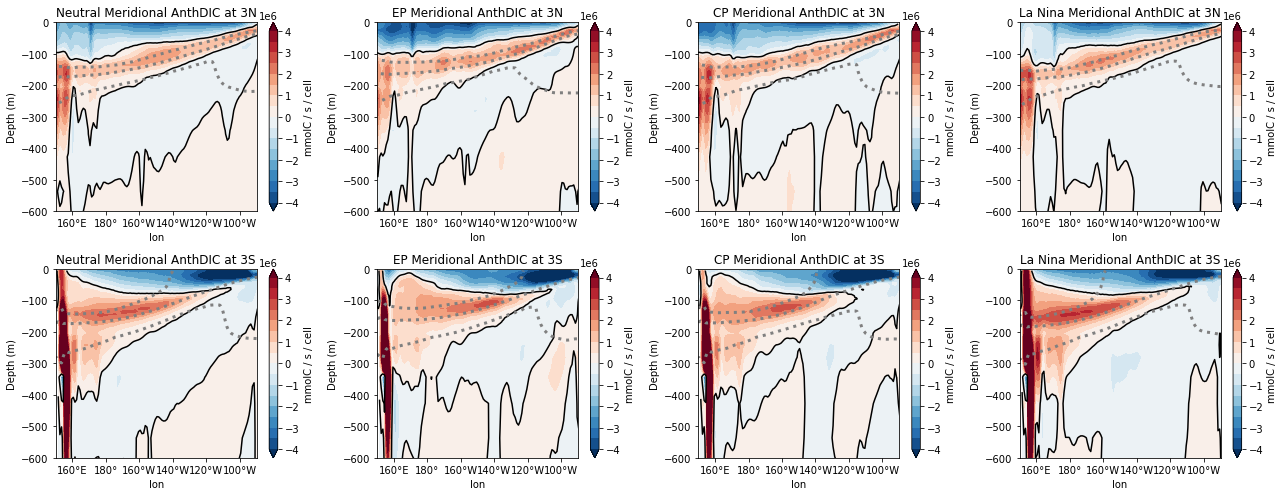

Postive and negative sums [ 30.726313 -36.18504 ]
Total Sum -5.4587249755859375
39338060.0


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 31.796509 -39.983593]
Total Sum -8.187085151672363
36045356.0


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 33.255547 -40.995224]
Total Sum -7.739676475524902
41431972.0


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 31.53559 -38.74262]
Total Sum -7.207032203674316
47919630.0


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 42.311024 -34.03084 ]
Total Sum 8.280184745788574
56212240.0


<timed exec>:47: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 39.79327  -32.911854]
Total Sum 6.8814191818237305
48794908.0


<timed exec>:64: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 43.115158 -32.933388]
Total Sum 10.181767463684082
54774550.0


<timed exec>:73: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 47.271408 -37.41217 ]
Total Sum 9.859235763549805
72246320.0


<timed exec>:86: UserWarning: FixedFormatter should only be used together with FixedLocator


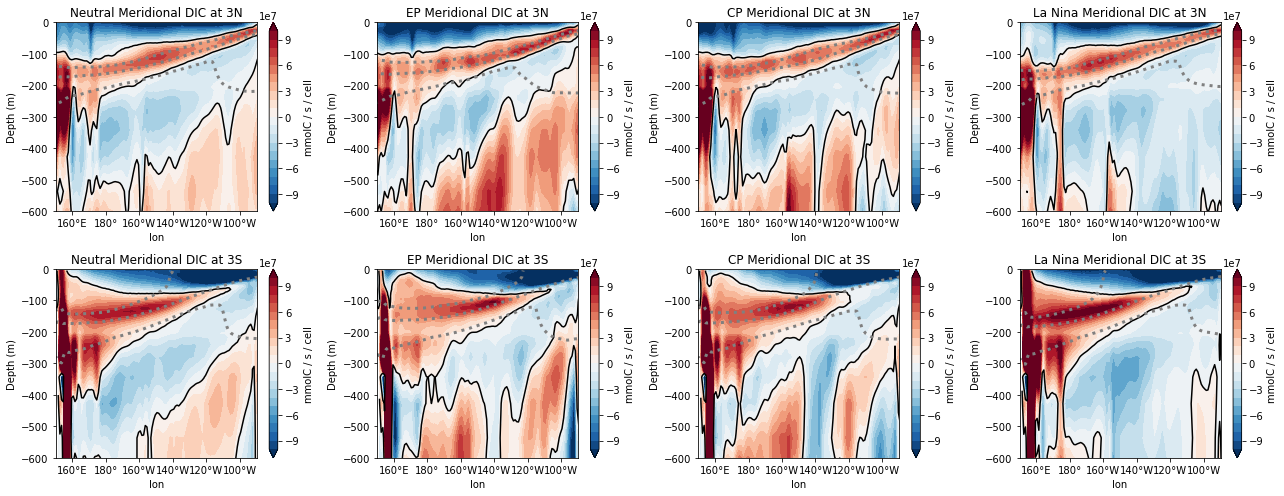

CPU times: user 1min 44s, sys: 20.8 s, total: 2min 5s
Wall time: 17min 49s


,surface_sum,upperthermocline_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum
Neutral Meridional AnthDIC at 3N,-0.583321,0.199024,0.183075,0.009280,-0.191943,-0.570982,0.686767,-0.878709
EP Meridional AnthDIC at 3N,-0.752398,0.190861,0.180769,0.017322,-0.363446,-0.745824,0.693948,-1.057394
CP Meridional AnthDIC at 3N,-0.708529,0.201685,0.178549,0.030558,-0.297736,-0.703720,0.718614,-1.016351
Nina Meridional AnthDIC at 3N,-0.576400,0.213306,0.184857,-0.001579,-0.179815,-0.550286,0.700367,-0.880182
Neutral Meridional AnthDIC at 3S,-0.031019,-0.126905,0.276075,0.076774,0.194926,-0.550290,0.980783,-0.785857
EP Meridional AnthDIC at 3S,-0.124495,-0.061423,0.253343,0.084956,0.152381,-0.510475,0.944766,-0.792385
CP Meridional AnthDIC at 3S,-0.020408,-0.165959,0.292525,0.096513,0.202671,-0.557410,0.972044,-0.769373
Nina Meridional AnthDIC at 3S,0.076264,-0.153768,0.280568,0.061415,0.264479,-0.528010,1.089325,-0.824847
Neutral Meridional DIC at 3N,-20.656870,7.289727,7.498618,0.409801,-5.458725,-20.408516,30.726313,-36.185040
EP Meridional DIC at 3N,-23.716133,6.602804,7.333412,1.592833,-8.187085,-23.370892,31.796509,-39.983593


In [30]:
%%time
longitude_labels=['','160°E','180°','160°W','140°W','120°W','100°W']
densitylevs=[1023,1024.5,1026.3]#,1026.7,1027,1027.5]
ylim=-600

plot=True
if plot==True:
    N_S_data_holder=[anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)),
                     dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))]
                     #((grid_multiplier_lon*(anth_dic_tx_v_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T)]

    N_S_names=['Meridional AnthDIC','Meridional DIC']#,'Old Attempt']


    for i, N_S_data in enumerate(N_S_data_holder):
        plt.figure(figsize=(18,7))

        for xi,lat in enumerate([3,-3]):
            #Client.restart()
            #time.sleep(10)
            adic_tx_n=N_S_data.sel(lat=lat,method='nearest')#(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T
            if lat==3: 
                direct='3N'
                adic_tx_n=adic_tx_n*-1  # Calculate Transport OUT of the box
            if lat==-3: direct='3S'

            
            
            if ((i==0)|(i==2)): 
                levs=np.arange(-4e6,4.5e6,5e5)
            elif i==1: 
                levs=np.arange(-1e8,1.1e8,1e7)
            #else: levs=np.arange(-10,10,1)
            contour=[0]#60,-60]
            
         

            subpl=plt.subplot(2,4,1+(xi*4))        
            ax=adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_n,enso_months=neutral_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_neutral.index=[f'Neutral {N_S_names[i]} at {direct}']
            #print(asum)
            plt.title(f'Neutral {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            subpl.set_xticklabels(longitude_labels)
            plt.ylabel('Depth (m)')
            
            #cbar=plt.colorbar(ax)
            #cbar.set_label()#, rotation=270)

            subpl=plt.subplot(2,4,2+(xi*4))
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_n,enso_months=ep_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_ep.index=[f'EP {N_S_names[i]} at {direct}']
            #print(asum)
            plt.title(f'EP {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            subpl=plt.subplot(2,4,3+(xi*4))
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_n,enso_months=cp_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_cp.index=[f'CP {N_S_names[i]} at {direct}']
            plt.title(f'CP {N_S_names[i]} at {direct}')
            subpl.set_xticklabels(longitude_labels)
            plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            subpl=plt.subplot(2,4,4+(xi*4))
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_n.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_n,enso_months=nina_events,lat=lat)
            (cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            asum_nina.index=[f'Nina {N_S_names[i]} at {direct}']
            plt.title(f'La Nina {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            subpl.set_xticklabels(longitude_labels)
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            
            temp_holder=pd.concat([asum_neutral,asum_ep,asum_cp,asum_nina])#,index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
        plt.tight_layout()
        plt.show()
        
dic_transport_through_box                                     

In [31]:
asum_neutral#.index=['hi']

,surface_sum,upperthermocline_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum
Neutral Meridional DIC at 3S,-1.358094,-6.346204,11.049176,4.935304,8.280185,-21.992031,42.311024,-34.030842


In [32]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45795 instead
  warnings.warn(


In [33]:
time.sleep(20)

In [34]:
cluster

In [35]:
anth_dic_u_tx

<xarray.DataArray '__xarray_dataarray_variable__' (time: 731, st_ocean: 30, lat: 140, lon: 170)>
dask.array<rechunk-merge, shape=(731, 30, 140, 170), dtype=float32, chunksize=(103, 15, 35, 85), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * st_ocean  (st_ocean) float64 -5.0 -15.0 -25.0 -35.0 ... -665.4 -812.8 -969.1
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5

### Plot 3+4: Western and Eastern Faces

Postive and negative sums [ 0.6289853 -0.3245144]
Total Sum 0.304470956325531
5692064.5


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.52658737 -0.38910037]
Total Sum 0.13748691976070404
4732986.0


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.6133987  -0.42744258]
Total Sum 0.18595603108406067
5551011.5


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.6426511  -0.29713085]
Total Sum 0.3455201983451843
5979557.0


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.11598948 -0.3072051 ]
Total Sum -0.1912156492471695
2339696.0


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.15499473 -0.296735  ]
Total Sum -0.14174027740955353
2512704.8


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.1462926  -0.28732714]
Total Sum -0.1410345435142517
3451568.5


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 0.10218932 -0.3195793 ]
Total Sum -0.21738998591899872
2231681.8


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


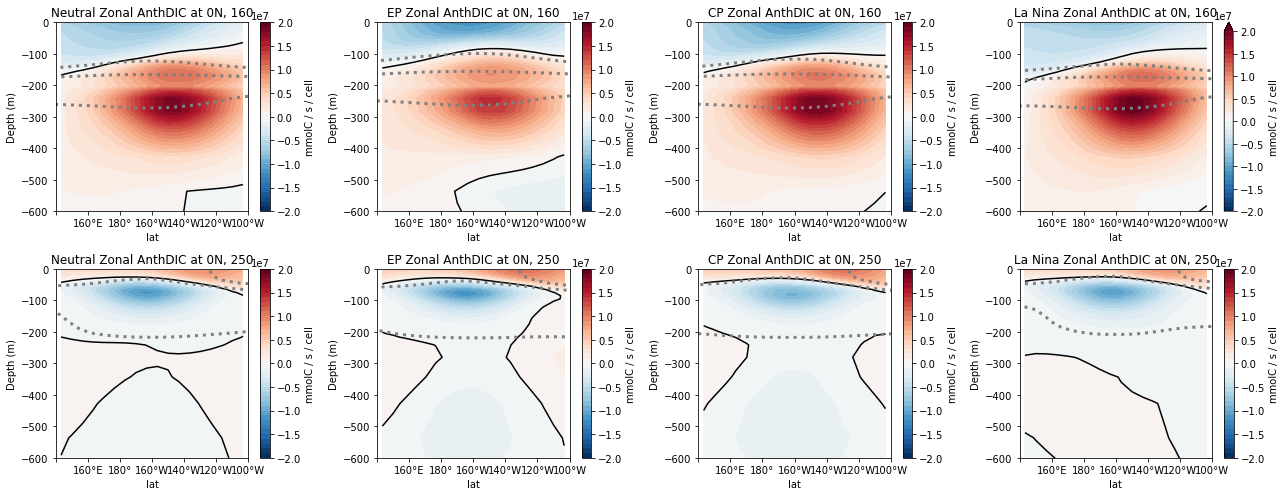

Postive and negative sums [ 29.880878 -11.357615]
Total Sum 18.523265838623047
270409950.0


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 23.35194  -13.696192]
Total Sum 9.655749320983887
212783070.0


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 29.773596 -14.562162]
Total Sum 15.21143627166748
271297280.0


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [ 32.39911  -10.048145]
Total Sum 22.350967407226562
300400320.0


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [  5.307529 -16.167011]
Total Sum -10.859481811523438
114959440.0


<timed exec>:52: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [  6.520378 -16.564642]
Total Sum -10.04426383972168
111883010.0


<timed exec>:69: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [  6.007977 -17.185844]
Total Sum -11.177865028381348
140495340.0


<timed exec>:82: UserWarning: FixedFormatter should only be used together with FixedLocator


Postive and negative sums [  4.302637 -17.33332 ]
Total Sum -13.030685424804688
122254240.0


<timed exec>:95: UserWarning: FixedFormatter should only be used together with FixedLocator


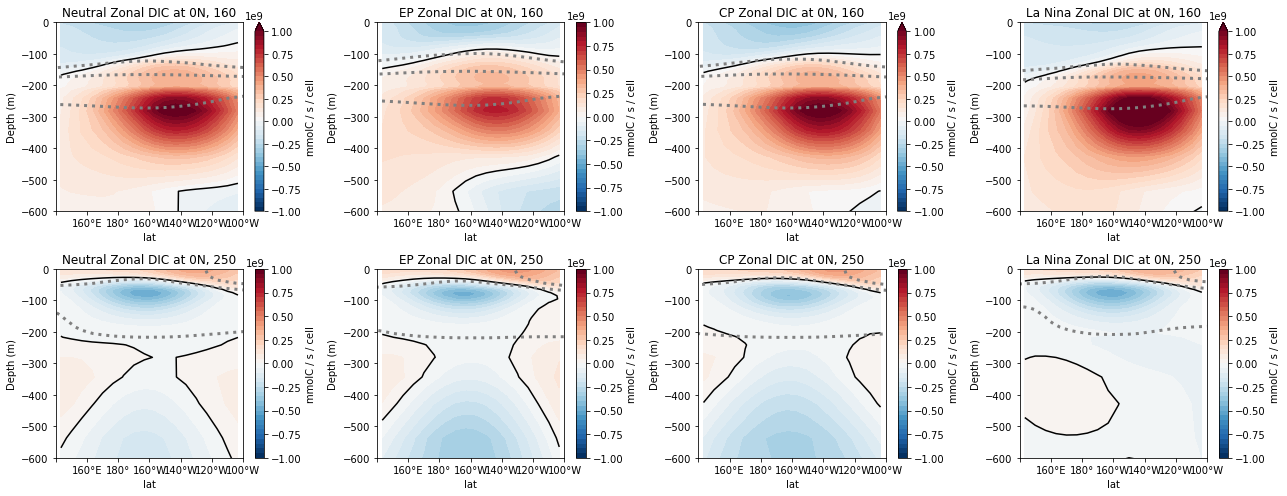

CPU times: user 3min 20s, sys: 38.3 s, total: 3min 58s
Wall time: 28min 51s


In [36]:
%%time

plot=True
if plot==True:

    #anth DIC
    E_W_data_holder=[anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700)),
                     dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-700))]
                     #((grid_multiplier_lat*(anth_dic_tx_u_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T*-1)] # Wrong Direction

    E_W_names=['Zonal AnthDIC','Zonal DIC']#,'Zonal Old Attempt']


    for i, E_W_data in enumerate(E_W_data_holder):
        #Client.restart()
        #time.sleep(10)
        ylim=-600
        plt.figure(figsize=(18,7))
        lons=[160,250]
        for xi, lon in enumerate(lons):
            if i==0 or i==2:
                levs=np.arange(-2e7,2.1e7,1e6)#None#np.arange(-20,22,2)
            elif i==1:# or i==3:
                levs=np.arange(-1e9,1.05e9,5e7)#None#np.arange(-1000,1100,100)
                
                
            #elif i<=4:  
            #levs=None#np.arange(-1e7,1e7,1e6)
            contour=[0]#60,-60]
            
            #lon=180
            lslice=slice(-3,3)

            
            #plt.subplot(251)
            subpl=plt.subplot(2,4,1+(xi*4))

            adic_tx_b=E_W_data.sel(lon=lon,method='nearest').sel(lat=lslice)#.T#grid_multiplier_lat.T*anth_dic_tx_u.sel(lon=lon,method='nearest')#.mean(dim='time')
            if lon==250:
                adic_tx_b*=-1 # Calculate Transport OUT of box. 

            #print(adic_tx_b)
            #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc(adic_tx_b,enso_months=neutral_events,lon=lon)
            asum_neutral.index=[f'Neutral {E_W_names[i]} at {lon}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'Neutral {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            subpl.set_xticklabels(longitude_labels)
            
            plt.ylabel('Depth (m)')
            plt.xlim([-3,3])

            subpl=plt.subplot(2,4,2+(xi*4))
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc(adic_tx_b,enso_months=ep_events,lon=lon)
            asum_ep.index=[f'EP {E_W_names[i]} at {lon}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'EP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.ylabel('Depth (m)')
            plt.xlim([-3,3])
            subpl.set_xticklabels(longitude_labels)
               
            subpl=plt.subplot(2,4,3+(xi*4))
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc(adic_tx_b,enso_months=cp_events,lon=lon)
            asum_cp.index=[f'CP {E_W_names[i]} at {lon}']
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'CP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            subpl=plt.subplot(2,4,4+(xi*4))
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
            adic_tx_b.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc(adic_tx_b,enso_months=nina_events,lon=lon)
            (cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=densitylevs,colors='gray',linestyles=":",linewidths=3)
            plt.title(f'La Nina {E_W_names[i]} at 0N, {lon}')
            asum_nina.index=[f'Nina {E_W_names[i]} at {lon}']
            #plt.xlim([150,270])
            plt.ylim([ylim,0])
            plt.xlim([-3,3])
            plt.ylabel('Depth (m)')
            subpl.set_xticklabels(longitude_labels)

            # Mmol DIC/m2/s
            #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
            
            temp_holder=pd.concat([asum_neutral,asum_ep,asum_cp,asum_nina])#,index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            
        plt.tight_layout()
        plt.show()
            #temp_holder

In [37]:
dic_transport_through_box

,surface_sum,upperthermocline_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum
Neutral Meridional AnthDIC at 3N,-0.583321,0.199024,0.183075,0.009280,-0.191943,-0.570982,0.686767,-0.878709
EP Meridional AnthDIC at 3N,-0.752398,0.190861,0.180769,0.017322,-0.363446,-0.745824,0.693948,-1.057394
CP Meridional AnthDIC at 3N,-0.708529,0.201685,0.178549,0.030558,-0.297736,-0.703720,0.718614,-1.016351
Nina Meridional AnthDIC at 3N,-0.576400,0.213306,0.184857,-0.001579,-0.179815,-0.550286,0.700367,-0.880182
Neutral Meridional AnthDIC at 3S,-0.031019,-0.126905,0.276075,0.076774,0.194926,-0.550290,0.980783,-0.785857
EP Meridional AnthDIC at 3S,-0.124495,-0.061423,0.253343,0.084956,0.152381,-0.510475,0.944766,-0.792385
CP Meridional AnthDIC at 3S,-0.020408,-0.165959,0.292525,0.096513,0.202671,-0.557410,0.972044,-0.769373
Nina Meridional AnthDIC at 3S,0.076264,-0.153768,0.280568,0.061415,0.264479,-0.528010,1.089325,-0.824847
Neutral Meridional DIC at 3N,-20.656870,7.289727,7.498618,0.409801,-5.458725,-20.408516,30.726313,-36.185040
EP Meridional DIC at 3N,-23.716133,6.602804,7.333412,1.592833,-8.187085,-23.370892,31.796509,-39.983593


In [38]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=2,memory="47GB")#47GB")
    #cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    
    client = Client(cluster)
    cluster.scale(cores=32)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36349 instead
  warnings.warn(


In [39]:
time.sleep(20)


### Plot 5+6: Upwelling and Outgassing (Vertical Top and Bottom Faces)
upwelling
anthupwelling

flux
anthflux


In [40]:
cluster

In [41]:
%%time
save_new_upwelling_density=False
if save_new_upwelling_density==True:
    upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
    anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


    upwelling=upwelling.interp(st_ocean=cafe_potential_density.st_ocean)
    anthupwelling=anthupwelling.interp(st_ocean=cafe_potential_density.st_ocean)


    surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.7)&(density_timefix.chunk('auto')<=1023.3)).mean(dim='st_ocean') #Average across a few pixels
    upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.7)&(density_timefix.chunk('auto')<=1023.3)).mean(dim='st_ocean') #Average across a few pixels
    anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    print('saving')
    surface_to_upperthermocline.to_netcdf('../processed_data/upwelling_through_layers/surface_to_upperthermocline.nc')
    print('saving')
    upper_to_lowerthermocline.to_netcdf('../processed_data/upwelling_through_layers/upper_to_lowerthermocline.nc')
    print('saving')
    lowerthermocline_to_thermostad.to_netcdf('../processed_data/upwelling_through_layers/lowerthermocline_to_thermostad.nc')
    print('saving')
    anth_surface_to_upperthermocline.to_netcdf('../processed_data/upwelling_through_layers/anth_surface_to_upperthermocline.nc')
    print('saving')
    anth_upper_to_lowerthermocline.to_netcdf('../processed_data/upwelling_through_layers/anth_upper_to_lowerthermocline.nc')
    print('saving')
    anth_lowerthermocline_to_thermostad.to_netcdf('../processed_data/upwelling_through_layers/anth_lowerthermocline_to_thermostad.nc')

surface_to_upperthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/surface_to_upperthermocline.nc').__xarray_dataarray_variable__
upper_to_lowerthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/upper_to_lowerthermocline.nc').__xarray_dataarray_variable__
lowerthermocline_to_thermostad=xr.open_dataset('../processed_data/upwelling_through_layers/lowerthermocline_to_thermostad.nc').__xarray_dataarray_variable__

anth_surface_to_upperthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/anth_surface_to_upperthermocline.nc').__xarray_dataarray_variable__
anth_upper_to_lowerthermocline=xr.open_dataset('../processed_data/upwelling_through_layers/anth_upper_to_lowerthermocline.nc').__xarray_dataarray_variable__
anth_lowerthermocline_to_thermostad=xr.open_dataset('../processed_data/upwelling_through_layers/anth_lowerthermocline_to_thermostad.nc').__xarray_dataarray_variable__


#Dens Calcs for upwelling
#dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
#anth_dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__

#dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
#anth_dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/upwelling_density.nc').tracer#.__xarray_dataarray_variable__
anth_dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anthupwelling_density.nc').tracer



#dic_w_tx_dens.sel(density=25,method='nearest').mean(dim='time').plot()


CPU times: user 195 ms, sys: 57.1 ms, total: 252 ms
Wall time: 1.39 s


Postive and negative sums [44.13533864 -0.3206619 ]
Total Sum 43.814676740360255
57565087.507472605
Postive and negative sums [45.23184763 -0.46495201]
Total Sum 44.76689562317286
58792116.71558506
Postive and negative sums [48.42848408 -0.26419111]
Total Sum 48.164292976943635
62091911.54811473
Postive and negative sums [45.2909909 -1.1806917]
Total Sum 44.11029919727119
63056195.12322251


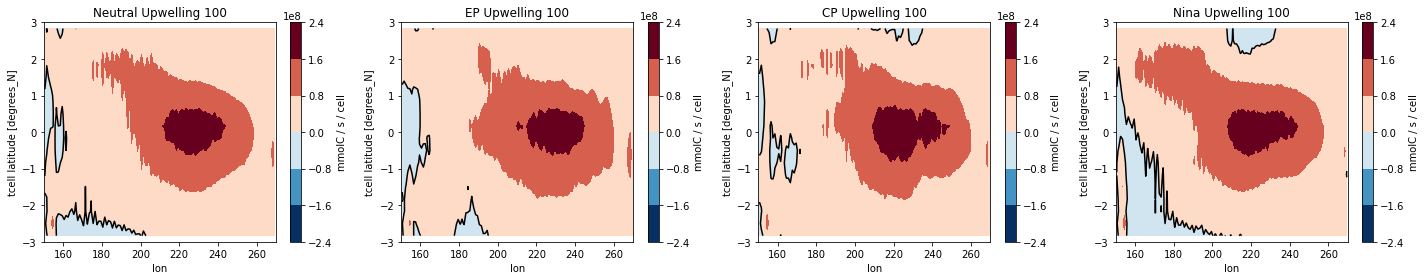

Postive and negative sums [ 1.09946852 -0.00959256]
Total Sum 1.089875953595149
1438280.44221886
Postive and negative sums [ 1.20404067 -0.01198344]
Total Sum 1.1920572371648726
1551270.8948383585
Postive and negative sums [ 1.22724586 -0.0087326 ]
Total Sum 1.2185132555992941
1574260.1493245175
Postive and negative sums [ 1.10838545 -0.03079446]
Total Sum 1.0775909908250938
1534253.192126908


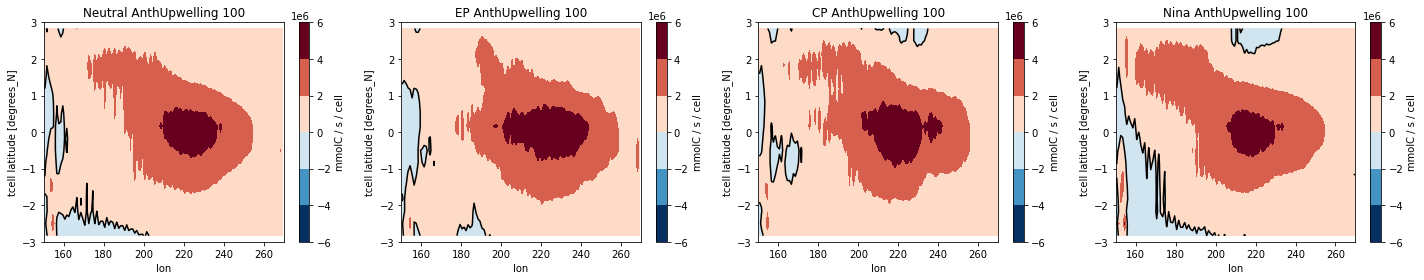

Postive and negative sums [ 4.83538038 -0.28947474]
Total Sum 4.5459056420704105
6610144.249364806
Postive and negative sums [ 9.47913975 -0.29646496]
Total Sum 9.182674787962489
12832204.136072908
Postive and negative sums [ 7.06585528 -0.22506597]
Total Sum 6.840789306388134
9349724.628624097
Postive and negative sums [ 3.98953316 -0.23563276]
Total Sum 3.7539004002909624
5263241.244356335


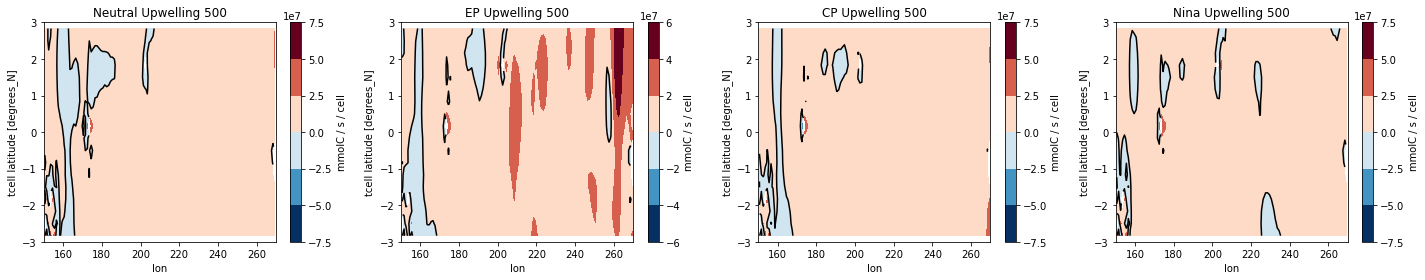

Postive and negative sums [ 0.0283136  -0.00279243]
Total Sum 0.025521175097138877
39089.969788790375
Postive and negative sums [ 0.05123468 -0.00306224]
Total Sum 0.0481724386957147
70403.92288294267
Postive and negative sums [ 0.04346274 -0.00253008]
Total Sum 0.04093265539568769
58210.60962029571
Postive and negative sums [ 0.02548011 -0.00242139]
Total Sum 0.023058721283032085
34352.42354524156


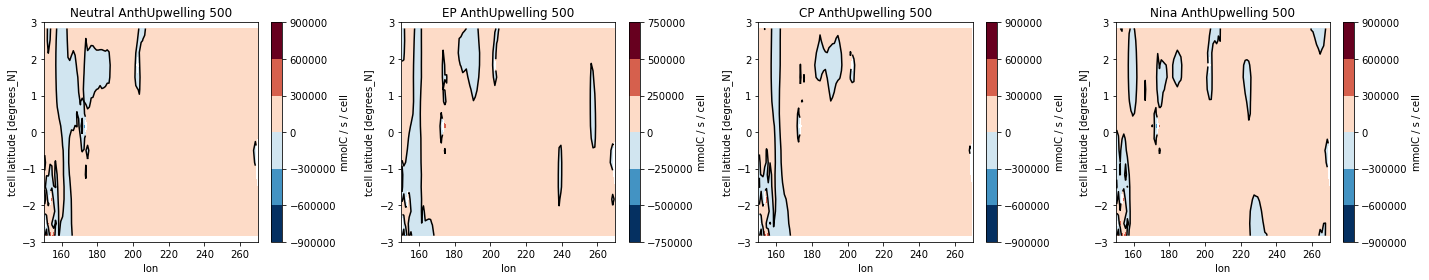

Postive and negative sums [30.47976148 -0.14083883]
Total Sum 30.338922652414702
38610853.96250131
Postive and negative sums [34.7276565  -0.09480541]
Total Sum 34.6328510940826
43886767.2478966
Postive and negative sums [35.4296534  -0.05535957]
Total Sum 35.37429383285797
43646734.2397831
Postive and negative sums [32.781029   -0.18447272]
Total Sum 32.596556275245156
42131955.68114492


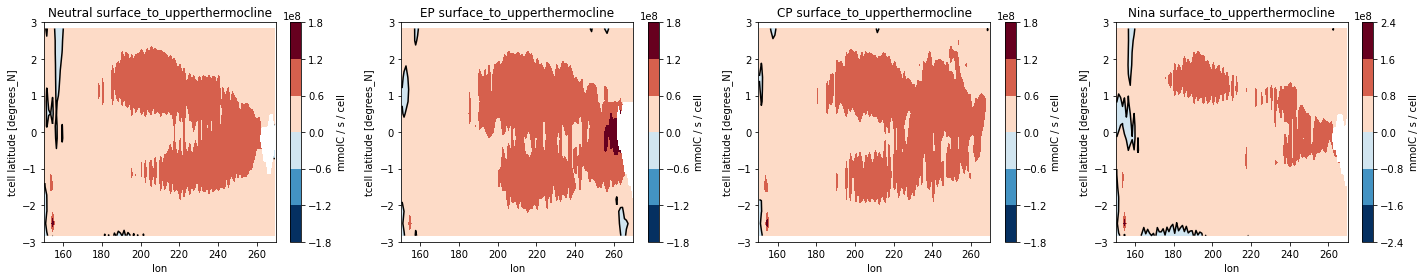

Postive and negative sums [43.15984554 -0.28277018]
Total Sum 42.87707536096775
56684465.046675906
Postive and negative sums [45.55969737 -0.62051114]
Total Sum 44.93918623796239
62410943.7769688
Postive and negative sums [47.57785992 -0.80472796]
Total Sum 46.773131953346834
63625339.10904495
Postive and negative sums [44.48238801 -0.68383782]
Total Sum 43.79855018397963
59636701.78845661


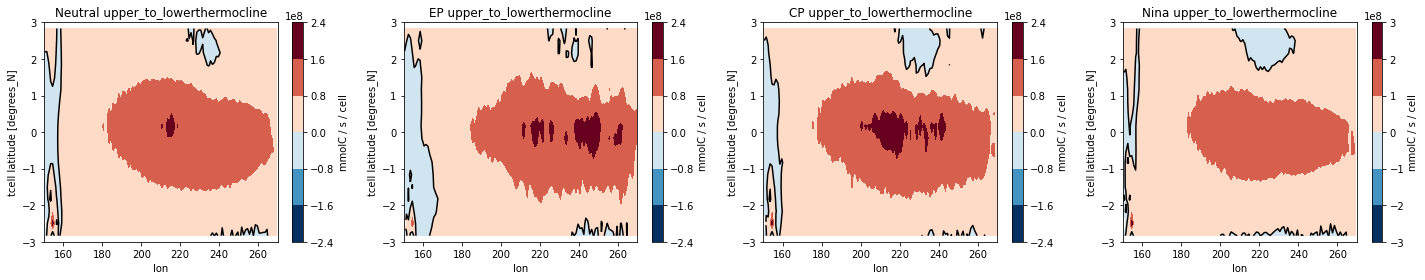

Postive and negative sums [22.52459779 -0.60909598]
Total Sum 21.915501812539738
28574584.353824835
Postive and negative sums [23.91592702 -0.55713281]
Total Sum 23.358794205795824
30441918.38465329
Postive and negative sums [26.96777979 -0.65926232]
Total Sum 26.308517472323146
34211181.288675755
Postive and negative sums [22.64190038 -0.61071382]
Total Sum 22.031186556532653
28504444.62144694


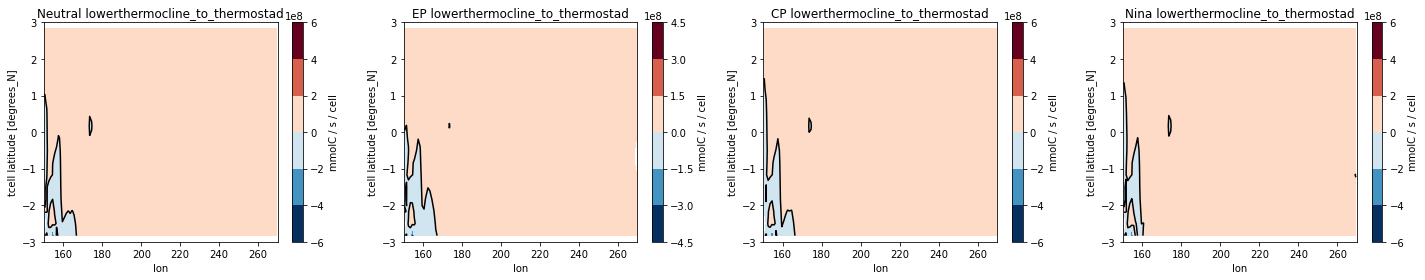

Postive and negative sums [ 0.81381548 -0.00389811]
Total Sum 0.8099173627820108
1030917.2061809755
Postive and negative sums [ 1.02375972 -0.00276989]
Total Sum 1.0209898303551335
1295005.8907252247
Postive and negative sums [ 0.93520409 -0.00170789]
Total Sum 0.933496190965333
1152102.836320174
Postive and negative sums [ 0.81839858 -0.00508539]
Total Sum 0.8133131910664023
1049807.7942252364


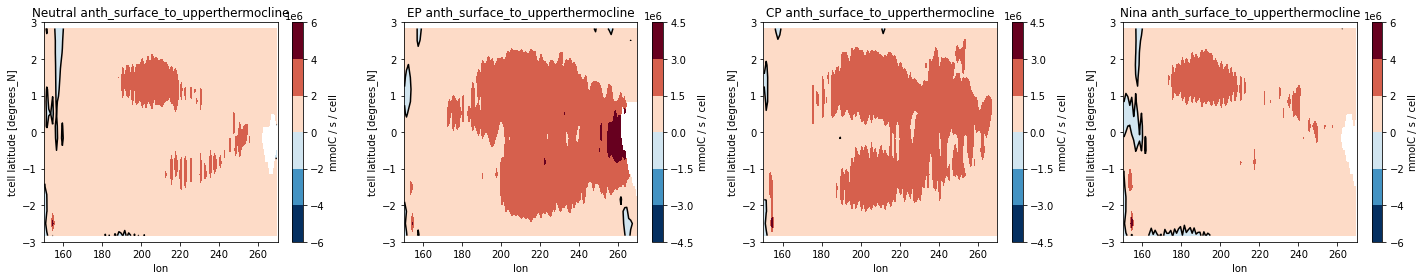

Postive and negative sums [ 1.11642169 -0.00754349]
Total Sum 1.1088782015609135
1468454.4343172314
Postive and negative sums [ 1.25770387 -0.01781957]
Total Sum 1.2398842933595344
1714007.562636492
Postive and negative sums [ 1.23182559 -0.02176862]
Total Sum 1.2100569699913173
1652323.737364167
Postive and negative sums [ 1.10989978 -0.01769914]
Total Sum 1.0922006398942665
1495609.856144425


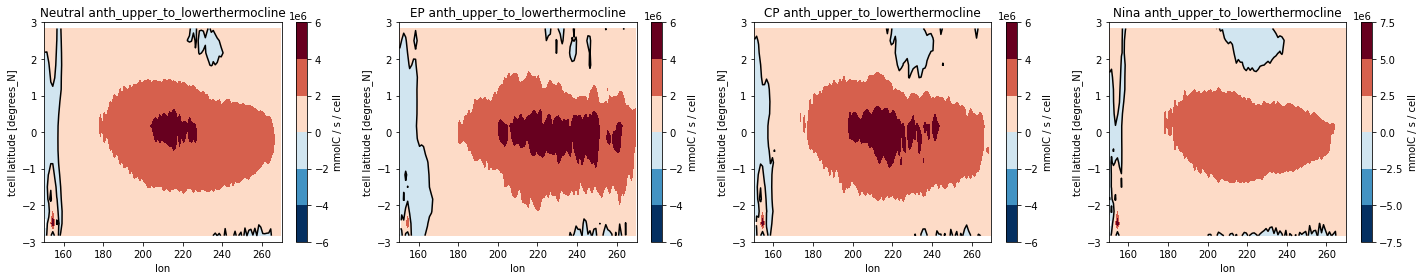

Postive and negative sums [ 0.3854683  -0.01231025]
Total Sum 0.37315805282154746
489003.02953202795
Postive and negative sums [ 0.41438027 -0.01165123]
Total Sum 0.40272903255485626
526692.0016176536
Postive and negative sums [ 0.46588646 -0.01344636]
Total Sum 0.4524400905028494
591021.0664354741
Postive and negative sums [ 0.3897737  -0.01242771]
Total Sum 0.3773459993089323
491163.6901515175


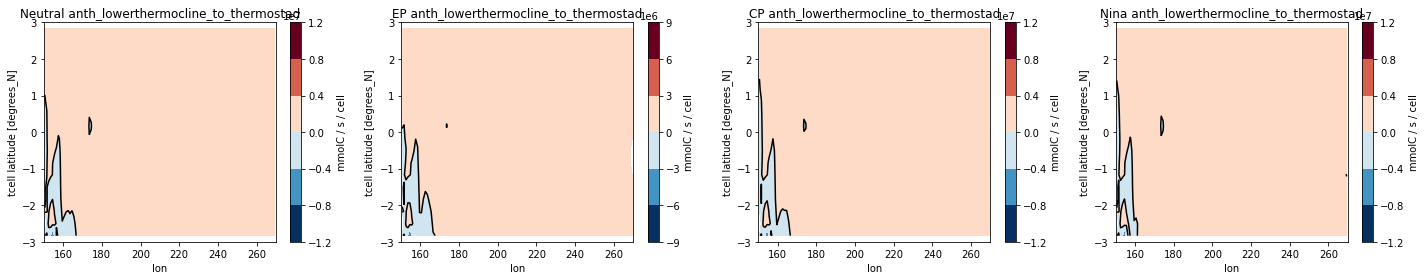

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [ 0.         -0.16120237]
Total Sum -0.16120237112045288
nan
Postive and negative sums [ 0.         -0.14437595]
Total Sum -0.14437595009803772
nan


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [ 0.         -0.15331078]
Total Sum -0.15331077575683594
nan
Postive and negative sums [ 0.         -0.15277693]
Total Sum -0.15277692675590515
nan


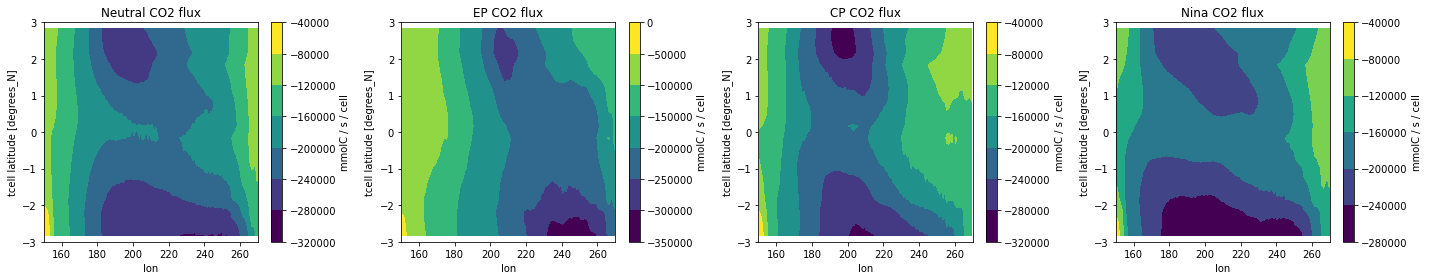

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [0.04449125 0.        ]
Total Sum 0.044491253793239594
54429.332
Postive and negative sums [0.04328502 0.        ]
Total Sum 0.04328501969575882
52953.664


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/xarray/plot/plot.py:1415: UserWarning: No contour levels were found within the data range.
  primitive = ax.contour(x, y, z, **kwargs)


Postive and negative sums [0.04012074 0.        ]
Total Sum 0.04012073576450348
49082.57
Postive and negative sums [0.04816891 0.        ]
Total Sum 0.048168912529945374
58928.473


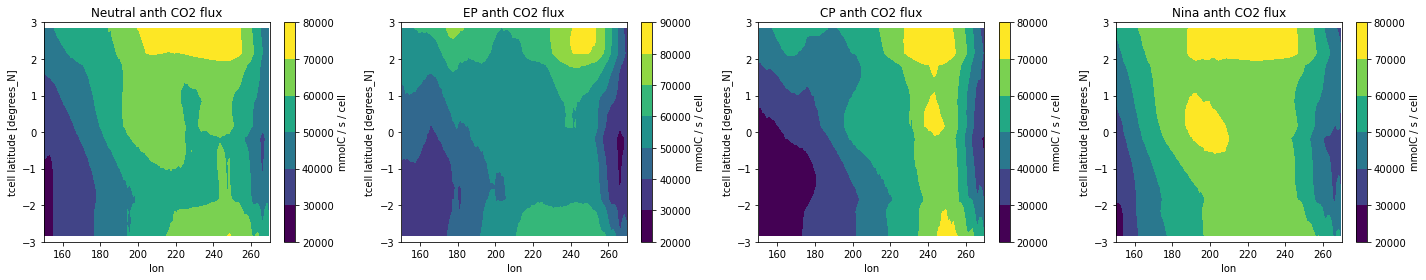

In [42]:
plot=True

if plot==True:
    density_timefix=cafe_potential_density#.sel(time=enso_months).mean(dim='time')
    #Density FIxed Upwelling??
    contour=[0]
    
    #surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
    #upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    #lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    #anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
    #anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
    #anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

    
    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     surface_to_upperthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     upper_to_lowerthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     lowerthermocline_to_thermostad.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     anth_surface_to_upperthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     anth_upper_to_lowerthermocline.sel(time=slice('2000-01-01','2020-01-01')),
                     anth_lowerthermocline_to_thermostad.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     flux.sel(time=slice('2000-01-01','2020-01-01'))*-1,
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))*-1]
                     
                     #dic_w_tx_dens.sel(density=1023,method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1023,method='nearest'),

                     #dic_w_tx_dens.sel(density=1024.5,method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1024.5,method='nearest'),

                     #dic_w_tx_dens.sel(density=1026.3, method='nearest'),
                     #anth_dic_w_tx_dens.sel(density=1026.3,method='nearest')]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','AnthUpwelling 100','Upwelling 500','AnthUpwelling 500',
               'surface_to_upperthermocline','upper_to_lowerthermocline','lowerthermocline_to_thermostad',
               'anth_surface_to_upperthermocline','anth_upper_to_lowerthermocline','anth_lowerthermocline_to_thermostad',
               'CO2 flux', 'anth CO2 flux']#,'Upwelling 23','Anthropogenic Upwelling 23','Upwelling 24.5','Anthropogenic Upwelling 24.5','Upwelling 26.3','Anthropogenic Upwelling 26.3']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat,enso_months=neutral_events,run_density_calc=False)

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat,enso_months=ep_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat,enso_months=cp_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat,enso_months=nina_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        name_str=''
        if pd.Series(T_B_names[i]).str.contains('_to_').iloc[0] ==True:
            if pd.Series(T_B_names[i]).str.contains('anth').iloc[0] ==True:
                name_str='Anth Upwelling'
            else:
                name_str='Upwelling'
        else:
            name_str=T_B_names[i]
            
        temp_holder=pd.DataFrame({f'Neutral {name_str}':asum_neutral,
                                  f'EP {name_str}':asum_ep,
                                  f'CP {name_str}':asum_cp,
                                  f'Nina {name_str}':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out']).T #Transpose because i did it backwards
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [43]:
dic_transport_through_box#=dic_transport_through_box[:-8]

,surface_sum,upperthermocline_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum,Upwelling 100 in,Upwelling 100 out,...,anth_surface_to_upperthermocline in,anth_surface_to_upperthermocline out,anth_upper_to_lowerthermocline in,anth_upper_to_lowerthermocline out,anth_lowerthermocline_to_thermostad in,anth_lowerthermocline_to_thermostad out,CO2 flux in,CO2 flux out,anth CO2 flux in,anth CO2 flux out
Neutral Meridional AnthDIC at 3N,-0.583321,0.199024,0.183075,0.009280,-0.191943,-0.570982,0.686767,-0.878709,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EP Meridional AnthDIC at 3N,-0.752398,0.190861,0.180769,0.017322,-0.363446,-0.745824,0.693948,-1.057394,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CP Meridional AnthDIC at 3N,-0.708529,0.201685,0.178549,0.030558,-0.297736,-0.703720,0.718614,-1.016351,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nina Meridional AnthDIC at 3N,-0.576400,0.213306,0.184857,-0.001579,-0.179815,-0.550286,0.700367,-0.880182,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Neutral Meridional AnthDIC at 3S,-0.031019,-0.126905,0.276075,0.076774,0.194926,-0.550290,0.980783,-0.785857,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nina CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.15277693,NaN,NaN
Neutral anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044491254,0.0
EP anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04328502,0.0
CP anth CO2 flux,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.040120736,0.0


In [44]:
dic_transport_through_box.to_csv('dic_tx.csv')

## End Box Estimate

In [9]:
# Bit of Data Wrangling


dic_transport_through_box.columns

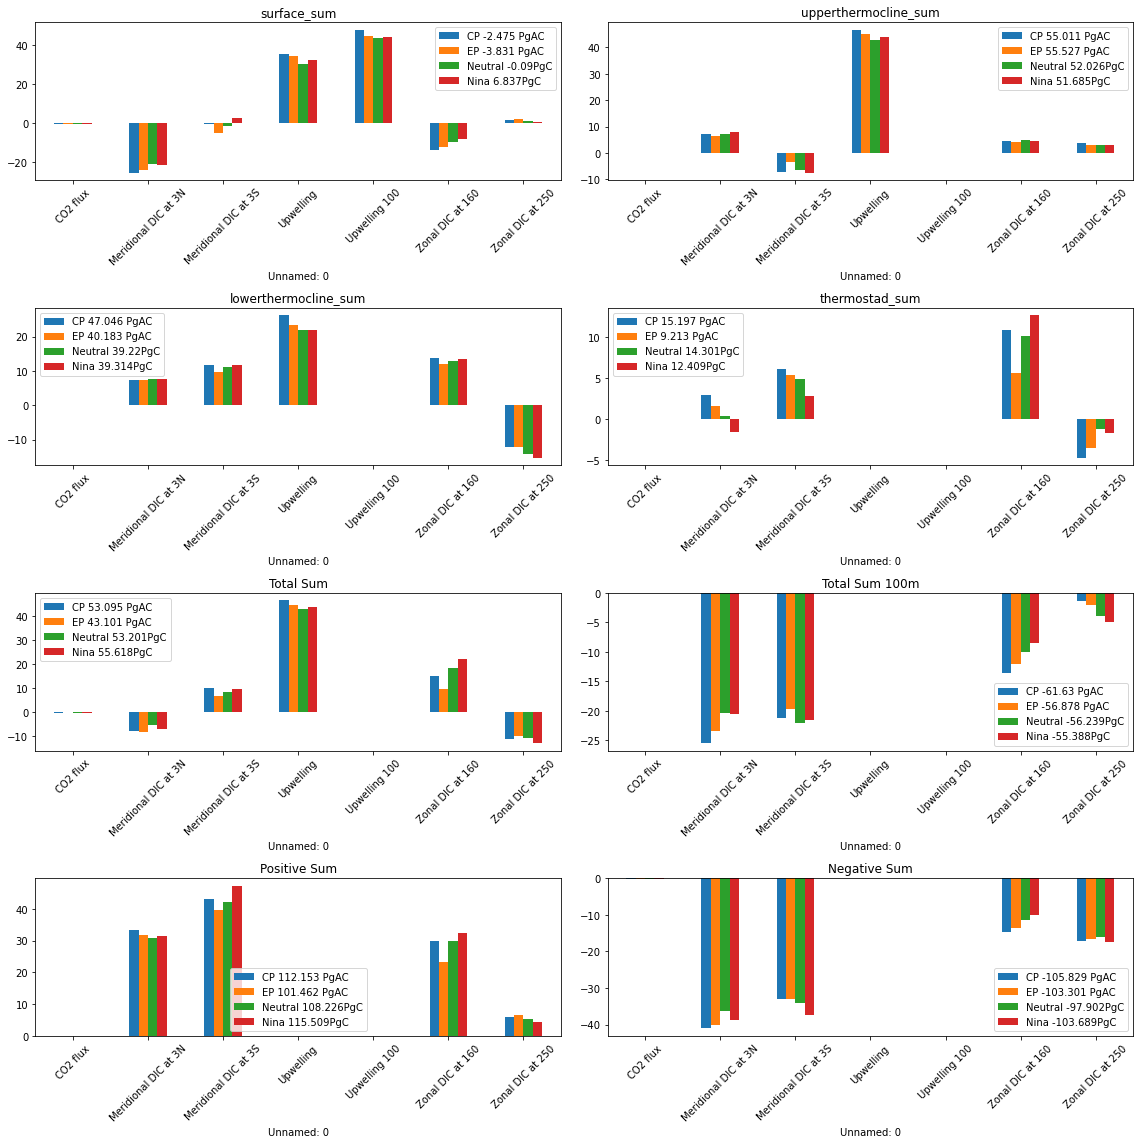

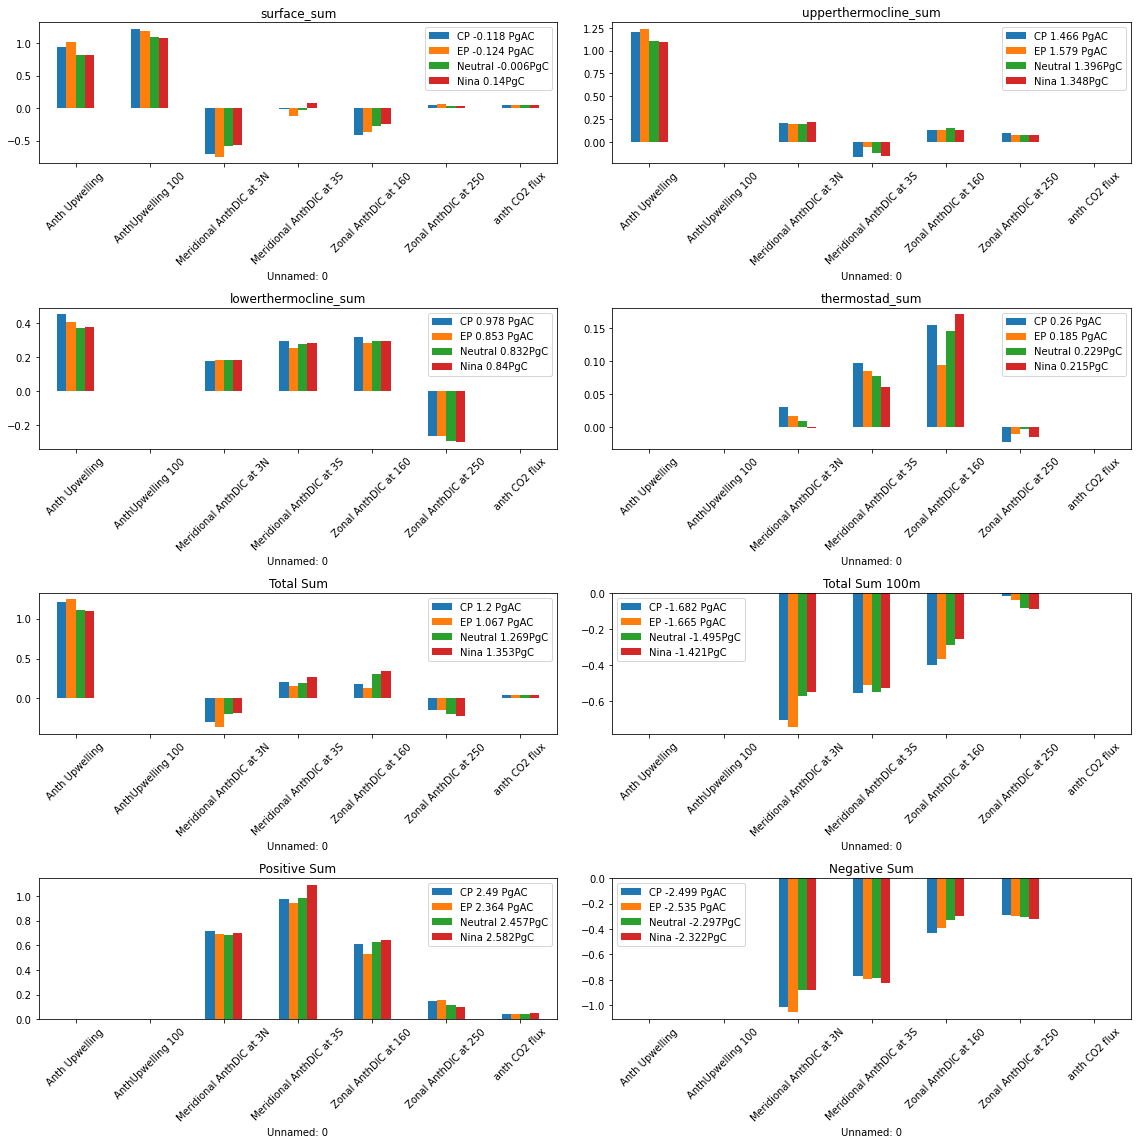

In [53]:
region=''#'_big'
dic_transport_through_box = pd.read_csv(f'dic_tx{region}.csv',index_col=0)

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['Upwelling 100 in']+dic_transport_through_box['Upwelling 100 out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['AnthUpwelling 100 in']+dic_transport_through_box['AnthUpwelling 100 out'])

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(
    dic_transport_through_box['surface_to_upperthermocline in']+dic_transport_through_box['surface_to_upperthermocline out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(
    dic_transport_through_box['anth_surface_to_upperthermocline in']+dic_transport_through_box['anth_surface_to_upperthermocline out'])


dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
    dic_transport_through_box['upper_to_lowerthermocline in']+dic_transport_through_box['upper_to_lowerthermocline out'])
dic_transport_through_box['upperthermocline_sum']=dic_transport_through_box['upperthermocline_sum'].fillna(
    dic_transport_through_box['anth_upper_to_lowerthermocline in']+dic_transport_through_box['anth_upper_to_lowerthermocline out'])

dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['lowerthermocline_to_thermostad in']+dic_transport_through_box['lowerthermocline_to_thermostad out'])

dic_transport_through_box['lowerthermocline_sum']=dic_transport_through_box['lowerthermocline_sum'].fillna(
    dic_transport_through_box['anth_lowerthermocline_to_thermostad in']+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['surface_sum']=dic_transport_through_box['surface_sum'].fillna(dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])

#Total Sum 	Total Sum 100m 	Positive Sum 	Negative Sum
dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['CO2 flux in']+dic_transport_through_box['CO2 flux out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])

dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in']+dic_transport_through_box['anth CO2 flux out'])
dic_transport_through_box['Positive Sum']=dic_transport_through_box['Positive Sum'].fillna(
    dic_transport_through_box['anth CO2 flux in'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])
dic_transport_through_box['Negative Sum']=dic_transport_through_box['Negative Sum'].fillna(
    dic_transport_through_box['anth CO2 flux out'])#+dic_transport_through_box['anth_lowerthermocline_to_thermostad out'])


dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['anth_upper_to_lowerthermocline in']+dic_transport_through_box['anth_upper_to_lowerthermocline out'])
dic_transport_through_box['Total Sum']=dic_transport_through_box['Total Sum'].fillna(
    dic_transport_through_box['upper_to_lowerthermocline in']+dic_transport_through_box['upper_to_lowerthermocline out'])
    
    
dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 100 in','Upwelling 100 out','AnthUpwelling 100 in','AnthUpwelling 100 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)

dic_transport_through_box=dic_transport_through_box.drop(['Upwelling 500 in','Upwelling 500 out','AnthUpwelling 500 in','AnthUpwelling 500 out'],axis=1)#,'Upwelling 23 out','Upwelling 24.5 in','Upwelling 24.5 out','Upwelling 26.3 in','Upwelling 26.3 out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['surface_to_upperthermocline in','surface_to_upperthermocline out','anth_surface_to_upperthermocline in','anth_surface_to_upperthermocline out','upper_to_lowerthermocline in','upper_to_lowerthermocline out','anth_upper_to_lowerthermocline in','anth_upper_to_lowerthermocline out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['lowerthermocline_to_thermostad in','lowerthermocline_to_thermostad out','anth_lowerthermocline_to_thermostad in','anth_lowerthermocline_to_thermostad out'],axis=1)
dic_transport_through_box=dic_transport_through_box.drop(['CO2 flux in','CO2 flux out','anth CO2 flux in','anth CO2 flux out'],axis=1)
dic_transport_through_box=dic_transport_through_box.dropna(thresh=1)

dic_transport_through_box.to_csv(f'dic_tx2{region}.csv')

t=pd.read_csv(f'dic_tx2{region}.csv').replace(0,np.nan)
merged=t.groupby('Unnamed: 0').mean().sort_values('Unnamed: 0').round(3)#agg(np.mean())

merged['enso_phase']=merged.index.str.split(' ').str[0]
merged.index=merged.index.str.split(' ').str[1:].str.join(' ')#.groupby('surface_sum')

merged.to_csv(f'dic_tx3{region}.csv')
merged



# Prepare Data for Plotting
dic_transport_through_box=pd.read_csv(f'dic_tx3{region}.csv',index_col=0).replace(0,np.nan)

names=dic_transport_through_box.index

new_tx=dic_transport_through_box[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)
        
    
# Plotting
plt.figure(figsize=(16,16))
for i,col in enumerate(new_tx.columns[:-1]):
    ax=plt.subplot(4,2,i+1)
    df=new_tx[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar(ax=ax)#plt.show()
    #df.drop('Upwelling 100').groupby('enso_phase').sum().T['EP'].values
    sum_of_rows=df.drop('Upwelling 100').groupby('enso_phase').sum()#
    #print(sum_of_rows
    plt.title(col)
    plt.xticks(rotation=45)
    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
            f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
            f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
            f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC'])# Make sure this doesnt break anything
plt.tight_layout()
# Plotting Anth
plt.figure(figsize=(16,16))
for i, col in enumerate(new_tx_anth.columns[:-1]):
    ax=plt.subplot(4,2,i+1)
    df=new_tx_anth[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar(ax=ax)#plt.show()
    #plt.legend(['CP','EP','Neutral','Nina'])# Make sure this doesnt break anything
    plt.title(col)
    sum_of_rows=df.drop('AnthUpwelling 100').groupby('enso_phase').sum()#
    #print(sum_of_rows)
    plt.xticks(rotation=45)
    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
                f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
                f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
                f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC'])# Make sure this doesnt break anything
plt.tight_layout()

In [5]:
new_tx

,surface_sum,upperthermocline_sum,lowerthermocline_sum,thermostad_sum,Total Sum,Total Sum 100m,Positive Sum,Negative Sum,enso_phase
Unnamed: 0,,,,,,,,,
CO2 flux,-0.153,NaN,NaN,NaN,-0.153,NaN,NaN,-0.153,CP
Meridional DIC at 3N,-25.271,7.241,7.381,2.909,-7.740,-25.426,33.256,-40.995,CP
Meridional DIC at 3S,-0.383,-7.334,11.763,6.136,10.182,-21.206,43.115,-32.933,CP
Upwelling,35.374,46.773,26.309,NaN,NaN,NaN,NaN,NaN,CP
Upwelling 100,48.164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CP
Zonal DIC at 160,-13.835,4.404,13.751,10.892,15.211,-13.628,29.774,-14.562,CP
Zonal DIC at 250,1.793,3.927,-12.158,-4.740,-11.178,-1.370,6.008,-17.186,CP
CO2 flux,-0.144,NaN,NaN,NaN,-0.144,NaN,NaN,-0.144,EP
Meridional DIC at 3N,-23.716,6.603,7.333,1.593,-8.187,-23.371,31.797,-39.984,EP


array([-103.301])

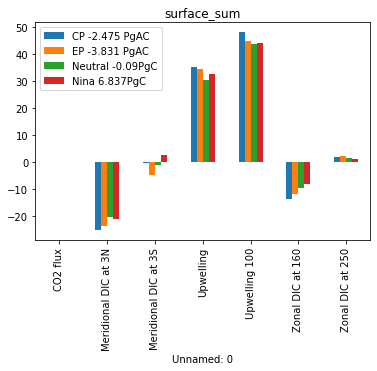

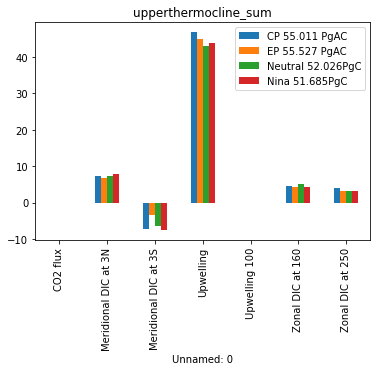

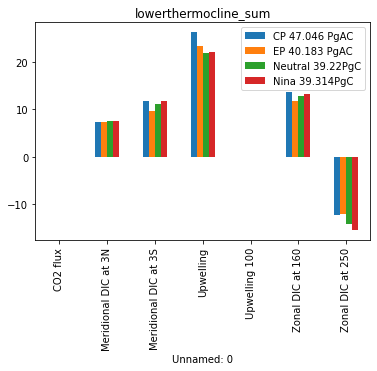

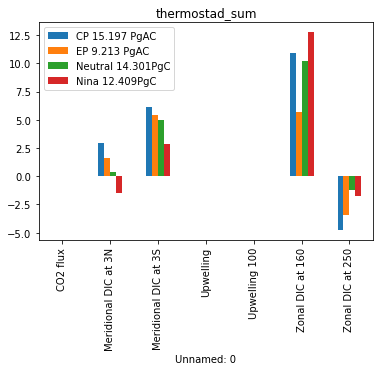

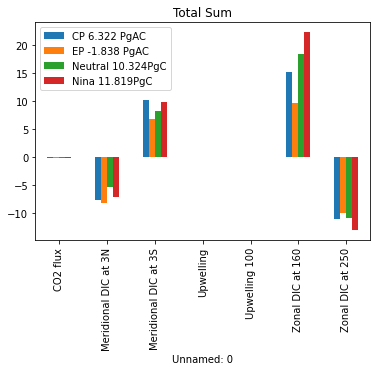

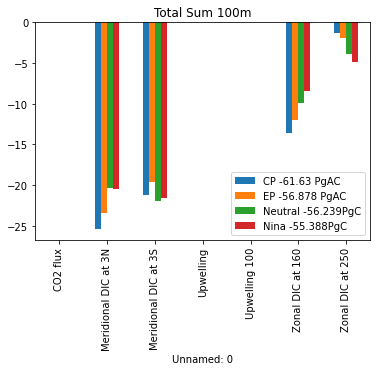

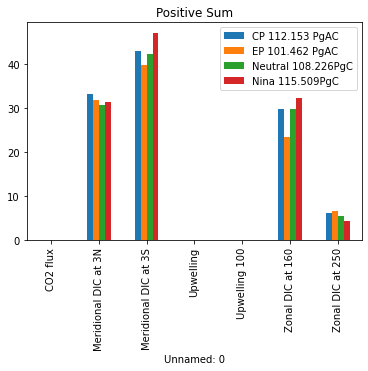

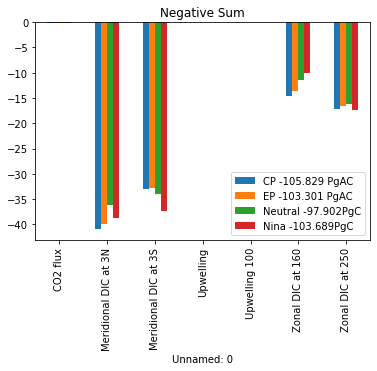

In [41]:
for col in new_tx.columns[:-1]:
    df=new_tx[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar()#plt.show()
    #df.drop('Upwelling 100').groupby('enso_phase').sum().T['EP'].values
    sum_of_rows=df.drop('Upwelling 100').groupby('enso_phase').sum()#
    #print(sum_of_rows
    plt.title(col)
    
    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
            f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
            f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
            f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC'])# Make sure this doesnt break anything

,surface_sum
enso_phase,
CP,-0.118
EP,-0.124
Neutral,-0.006
Nina,0.140


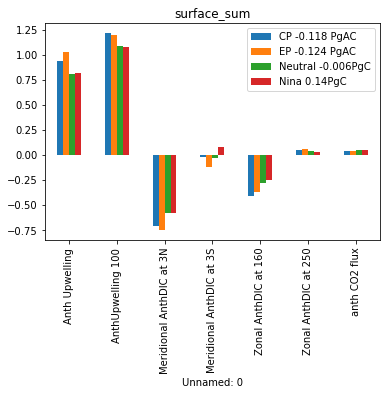

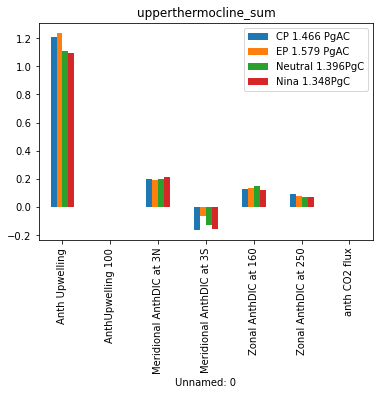

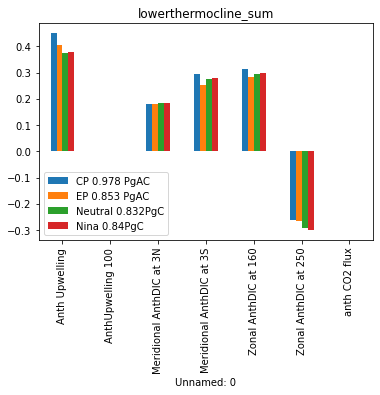

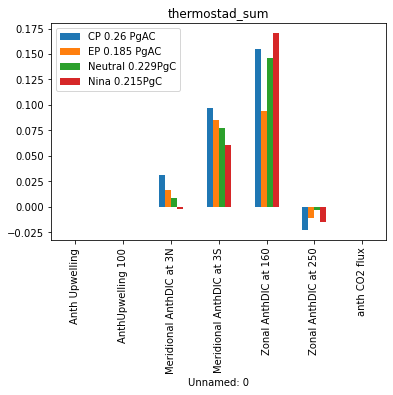

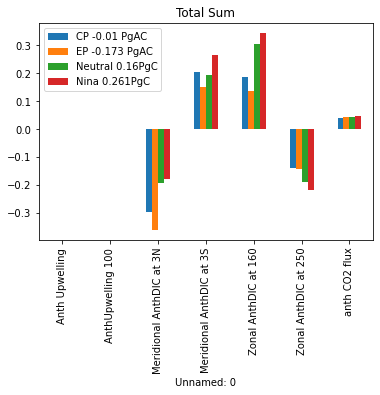

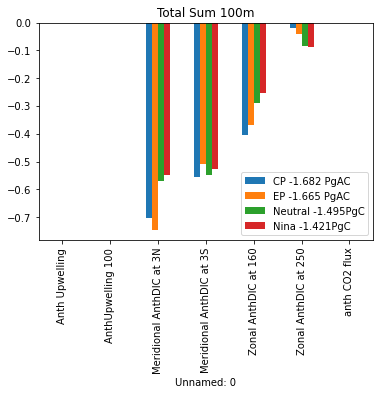

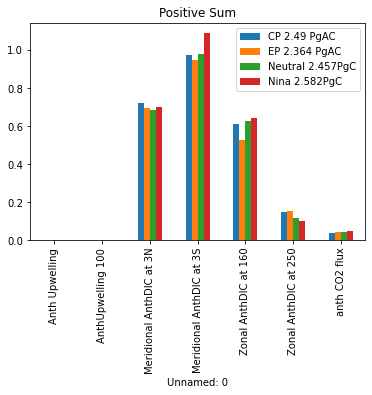

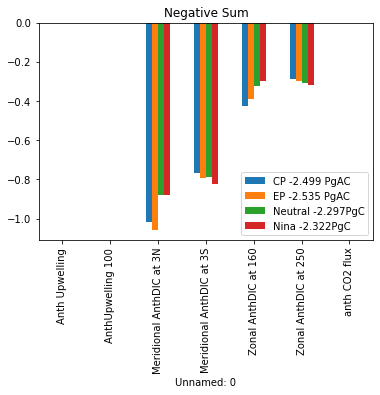

In [40]:
for col in new_tx_anth.columns[:-1]:
    df=new_tx_anth[[col,'enso_phase']]#.plot.bar()
    df.pivot(columns='enso_phase').plot.bar()#plt.show()
    #plt.legend(['CP','EP','Neutral','Nina'])# Make sure this doesnt break anything
    plt.title(col)
    sum_of_rows=df.drop('AnthUpwelling 100').groupby('enso_phase').sum()#
    #print(sum_of_rows)
    plt.legend([f'CP {sum_of_rows.T["CP"].values[0].round(3)} PgAC',
                f'EP {sum_of_rows.T["EP"].values[0].round(3)} PgAC',
                f'Neutral {sum_of_rows.T["Neutral"].values[0].round(3)}PgC',
                f'Nina {sum_of_rows.T["Nina"].values[0].round(3)}PgC'])# Make sure this doesnt break anything

In [ ]:
new_tx_anth.index.str.split(' ').str[0]#.groupby('surface_sum')

In [ ]:
new_tx.index.str.split(' ').str[2]#.groupby('surface_sum')

In [ ]:
new_tx.index.str.split(' ').str[3]#.groupby('surface_sum')


In [ ]:
df=new_tx[[col,'enso_phase']]#set_index(['Unnamed: 0'])#.stack()

In [ ]:
#.groupby('enso_phase')[col].apply(list)
#df#.apply(pd.Series)

In [ ]:
grouper = df.groupby('enso_phase')
df = pd.concat([pd.Series(v[col].tolist(), name=k) for k, v in grouper], axis=1)

In [ ]:
new_tx#df

In [ ]:
dat=new_tx[[col,'enso_phase']]
dat.where(dat['enso_phase']=='CP').plot.bar()

In [ ]:
new_tx.groupby('enso_phase').plot.bar()

In [ ]:
plt.figure(figsize=(25,8))
ax=plt.subplot(111)
abs(new_tx).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
#plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
plt.figure(figsize=(25,8))
ax=plt.subplot(111)
abs(new_tx_anth).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
new_tx

In [ ]:
# SORT BY EACH FACE

face_data=[new_tx,new_tx_anth]

box_faces=['3s','3n','160','250','upwelling 500','upwelling 700','upwelling 100','flux']
box_faces=['3s','3n','160','250','upwelling 700','flux']


for i,df in enumerate(face_data):
    
    box_res=pd.DataFrame()
    for face in box_faces:
        result=df[df.index.str.lower().str.contains(face)]
        #print(result)
        result1=result.mean()
        result1.name=face
        #print(result.mean())
        box_res=box_res.append(result1)
        #print(result)
    if i==0:
        print('Total DIC transport')
    elif i==1:
        print('Anth DIC transport')
        
    plt.figure(figsize=(12,8))
    ax=plt.subplot(111)
    box_res.plot.bar(ax=ax)
    plt.axhline(0,c='k')
    plt.show()
    
    print(box_res)
    #plt.figure(figsize=(12,5))
    print(box_res.mean())
    box_res.mean().plot.bar()
    plt.axhline(0,c='k')
    plt.show()

In [ ]:
# SORT BY IN AND OUT
# Calculate Total In / Out transport
face_data=[new_tx,new_tx_anth]
box_faces=[' in',' out']
for a,df in enumerate(face_data):
    box_res=pd.DataFrame()
    for i,face in enumerate(box_faces):
        
        direction=df[df.index.str.lower().str.contains(face)]
        result2=direction.mean()
        result2.name=str(face[1:])
        box_res=box_res.append(result2)
        #print(direction)
    if a==0:
        print(f'Total DIC transport {face}')
    elif a==1:
        print(f'Anth DIC transport {face}')
    print(box_res)
    print(box_res.mean())
#        print(box_res.mean())

In [ ]:
# Richards Depth Grid Calculation

docn=phys
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth

In [ ]:
# Old Upwelling Estimates

plot=True
if plot==True:

    #anth DIC
    T_B_data_holder=[upwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_100.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_500.sel(time=slice('2000-01-01','2020-01-01')),
                     upwelling_700.sel(time=slice('2000-01-01','2020-01-01')),
                     anthupwelling_700.sel(time=slice('2000-01-01','2020-01-01')),

                     flux.sel(time=slice('2000-01-01','2020-01-01'))*-1,
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))*-1]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 100','Anthropogenic Upwelling 100','Upwelling 500','Anthropogenic Upwelling 500','Upwelling 700','Anthropogenic Upwelling 700','CO2 flux', 'anth CO2 flux']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        
        else: levs=None
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat,enso_months=neutral_events,run_density_calc=False)

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat,enso_months=ep_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat,enso_months=cp_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs,cbar_kwargs={'label':'mmolC / s / cell'})
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat,enso_months=nina_events,run_density_calc=False)
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{T_B_names[i]} in',f'{T_B_names[i]} out'])
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [ ]:
upwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').interp(st_ocean=cafe_wt.rename({'sw_ocean':'st_ocean'}).st_ocean).rolling(st_ocean=2).mean()*area_m2)#/1e6 # To Sverdrups


upwelling=upwelling.interp(st_ocean=cafe_potential_density.st_ocean)
anthupwelling=anthupwelling.interp(st_ocean=cafe_potential_density.st_ocean)


surface_to_upperthermocline=upwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
upper_to_lowerthermocline=upwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
lowerthermocline_to_thermostad=upwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')

anth_surface_to_upperthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1022.8)&(density_timefix.chunk('auto')<=1023.2)).mean(dim='st_ocean') #Average across a few pixels
anth_upper_to_lowerthermocline=anthupwelling.where((density_timefix.chunk('auto')>=1024.3)&(density_timefix.chunk('auto')<=1024.7)).mean(dim='st_ocean')
anth_lowerthermocline_to_thermostad=anthupwelling.where((density_timefix.chunk('auto')>=1026.1)&(density_timefix.chunk('auto')<=1026.5)).mean(dim='st_ocean')


